In [127]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle as pkl
import gc
import os
from scipy.linalg import svdvals

from src.simulation import sim_glm_pop
from src.theory import y_pred_full, covariance_full,  y_0_quad,  find_iso_rate, y_corrected_quad, find_iso_rate_input, cor_pred
from src.correlation_functions import rate, mean_by_region, tot_cross_covariance_matrix, two_pop_correlation, mean_pop_correlation, cov_to_cor
from src.plotting import raster_plot, abline
from src.generate_connectivity import excitatory_only, gen_adjacency, hippo_weights, macro_weights





In [210]:
def kth_term(J,R, k):
    result = np.zeros_like(J)
    for m in range(k):
        n = k -m 
        result +=  np.linalg.matrix_power(J, m) @ R @  np.linalg.matrix_power(J, n).T
    return result

def cov_terms_2_side(J0, g, h, b, N, nterms = 3, p = 2):
    J = macro_weights(J = J0, h3 = h, h1 = h, g = g)
    if p == 2:
        r = y_0_quad(J, b)
        gain =  2*(J@r+b)
        J_lin =J* gain[...,None]
    else: 
        J_lin = J
        r = np.linalg.inv(np.eye(6) - J_lin)@ b
    R = np.diag(r/N)
    result = [kth_term(J_lin, R, i)[3,3] for i in range(1,nterms+1)]
    return result

def cov_terms_1_side(J0, g, h, b, N, nterms = 3, p = 2):
    J = macro_weights(J = J0, h3 = h, h1 = h, g = g)
    if p == 2:
        r = y_0_quad(J, b)
        gain =  2*(J@r+b)
        J_lin =J* gain[...,None]
    else: 
        J_lin = J
        r = np.linalg.inv(np.eye(6) - J_lin)@ b
    R = np.diag(r/N)
    terms = np.zeros(nterms+1)
    for n in range(nterms+1):
        D_n = sum([np.linalg.matrix_power(J_lin, k) for k in range(n+1)])
        C_n = D_n @ R @ D_n.T
        terms[n] = C_n[3,3]
    result=np.zeros(nterms) 
    result  += terms[1:] 
    result  -= terms[0:-1]
    return result

def ca1_internal_cov(J0, g, h, b, N, p = 2):
    J = macro_weights(J = J0, h3 = h, h1 = h, g = g)
    if p == 2:
        r = y_0_quad(J, b)
        gain =  2*(J@r+b)
        J_lin =J* gain[...,None]
    else: 
        J_lin = J
        r = np.linalg.inv(np.eye(6) - J_lin)@ b
    R = np.diag(r/N)
    R1 = R[3:, 3:]
    J_CA1 = J_lin[3:, 3:]
    D_11 = np.linalg.inv(np.eye(3) - J_CA1)
    return (D_11 @ R1 @ D_11.T - R1)[0,0]

def ca3_internal_cov(J0, g, h, b, N, p = 2):
    J = macro_weights(J = J0, h3 = h, h1 = h, g = g)
    if p == 2:
        r = y_0_quad(J, b)
        gain =  2*(J@r+b)
        J_lin =J* gain[...,None]
    else: 
        J_lin = J
        r = np.linalg.inv(np.eye(6) - J_lin)@ b
    R = np.diag(r/N)
    R3 = R[:3, :3]
    J_CA3 = J_lin[:3, :3]
    D_33 = np.linalg.inv(np.eye(3) - J_CA3)
    return (D_33 @ R3 @ D_33.T)

def ca3_offdiag(J0, g, h, b, N, p = 2):
    J = macro_weights(J = J0, h3 = h, h1 = h, g = g)
    if p == 2:
        r = y_0_quad(J, b)
        gain =  2*(J@r+b)
        J_lin =J* gain[...,None]
    else: 
        J_lin = J
        r = np.linalg.inv(np.eye(6) - J_lin)@ b
    R = np.diag(r/N)
    R3 = R[:3, :3]
    J_CA3 = J_lin[:3, :3]
    D_33 = np.linalg.inv(np.eye(3) - J_CA3)
    return ((D_33 @ R3 @ D_33.T) - R3)

def ca1_inherited_cov(J0, g, h, b, N, p = 2):
    C_33 = ca3_internal_cov(J0, g, h, b, N, p = p)
    J = macro_weights(J = J0, h3 = h, h1 = h, g = g)
    if p == 2:
        r = y_0_quad(J, b)
        gain =  2*(J@r+b)
        J_lin =J* gain[...,None]
    else: 
        J_lin = J
        r = np.linalg.inv(np.eye(6) - J_lin)@ b
    R = np.diag(r/N)
    J_13 = J_lin[3:, :3]
    J_CA1 = J_lin[3:, 3:]
    D_11 = np.linalg.inv(np.eye(3) - J_CA1)
    return (D_11 @ J_13 @ C_33 @ J_13.T @ D_11.T)[0,0]

def ca1_inherited_cov_ca3_fixed(J0, g, h, b, N, p = 2):
    C_33 = ca3_internal_cov(J0, g, 1, b, N, p = p)
    J = macro_weights(J = J0, h3 = 1, h1 = h, g = g)
    if p == 2:
        r = y_0_quad(J, b)
        gain =  2*(J@r+b)
        J_lin =J* gain[...,None]
    else: 
        J_lin = J
        r = np.linalg.inv(np.eye(6) - J_lin)@ b
    R = np.diag(r/N)
    J_13 = J_lin[3:, :3]
    J_CA1 = J_lin[3:, 3:]
    D_11 = np.linalg.inv(np.eye(3) - J_CA1)
    return (D_11 @ J_13 @ C_33 @ J_13.T @ D_11.T)[0,0]

def total_CA1_cov(J0, g, h, b, N, p = 2):
    J = macro_weights(J = J0, h3 = h, h1 = h, g = g)
    if p == 2:
        r = y_0_quad(J, b)
        gain =  2*(J@r+b)
        J_lin =J* gain[...,None]
    else: 
        J_lin = J
        r = np.linalg.inv(np.eye(6) - J_lin)@ b
    R = np.diag(r/N)
    D= np.linalg.inv(np.eye(6) - J_lin)
    return (D @ R @ D.T - R)[3,3]

def total_CA1_cor(J0, g, h, b, N, p = 2):
    J = macro_weights(J = J0, h3 = h, h1 = h, g = g)
    if p == 2:
        r = y_0_quad(J, b)
        gain =  2*(J@r+b)
        J_lin =J* gain[...,None]
    else: 
        J_lin = J
        r = np.linalg.inv(np.eye(6) - J_lin)@ b
    R = np.diag(r/N)
    D= np.linalg.inv(np.eye(6) - J_lin)
    return (D @ R @ D.T - R)[3,3]/(D @ R @ D.T - R+np.diag(r))[3,3]

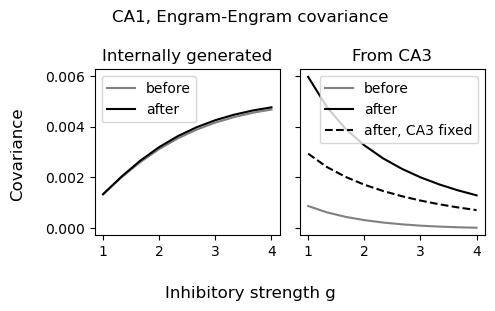

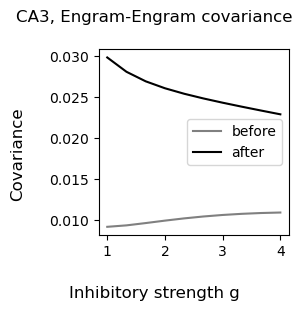

In [215]:
J0 = .2
g_min = 1
g_max = 4
n_g = 10
gs = np.linspace(g_min, g_max, n_g)
b = np.array([.5, .5, .7, .5, .5, .7])
N_E =60
N_I = 15
Ns =np.array([N_E, N_E, N_I,  N_E, N_E, N_I])
p= 1


internal_before = np.array([ca1_internal_cov(J0=J0, g=g, h=1,b=b, N=Ns, p = p) for g in gs])
inherited_before = np.array([ca1_inherited_cov(J0=J0, g=g, h=1,b=b, N=Ns, p = p) for g in gs])
ca3_before =  np.array([ca3_offdiag(J0=J0, g=g, h=1,b=b, N=Ns, p =1)[0,0] for g in gs])
total_before = internal_before  + inherited_before

internal_after = np.array([ca1_internal_cov(J0=J0, g=g, h=2,b=b, N=Ns, p = p) for g in gs])
inherited_after = np.array([ca1_inherited_cov(J0=J0, g=g, h=2,b=b, N=Ns, p = p) for g in gs])
inherited_after_fixed = np.array([ca1_inherited_cov_ca3_fixed(J0=J0, g=g, h=2,b=b, N=Ns, p = p) for g in gs])

ca3_after =  np.array([ca3_offdiag(J0=J0, g=g, h=2,b=b, N=Ns, p = p)[0,0] for g in gs])

total_after = internal_after + inherited_after


fig, axs = plt.subplots(1,2, sharey=True, sharex=True, figsize = (5,3))
axs[0].plot(gs, internal_before, color ="gray", label = "before")
axs[0].plot(gs, internal_after, color ="black", label = "after")
axs[0].legend()
axs[0].set_title("Internally generated")
fig.supxlabel("Inhibitory strength g")
fig.supylabel("Covariance")

axs[1].plot(gs, inherited_before, color ="gray", label = "before")
axs[1].plot(gs, inherited_after, color ="black", label = "after")
axs[1].plot(gs, inherited_after_fixed, color ="black", linestyle = "--", label = "after, CA3 fixed")
axs[1].set_title("From CA3")
axs[1].legend()
fig.suptitle("CA1, Engram-Engram covariance")
plt.tight_layout()

fig, ax = plt.subplots(figsize = (3,3))
ax.plot(gs, ca3_before, color ="gray", label = "before")
ax.plot(gs, ca3_after, color ="black", label = "after")
ax.legend()
fig.suptitle("CA3, Engram-Engram covariance")
fig.supxlabel("Inhibitory strength g")
fig.supylabel("Covariance")
plt.tight_layout()  


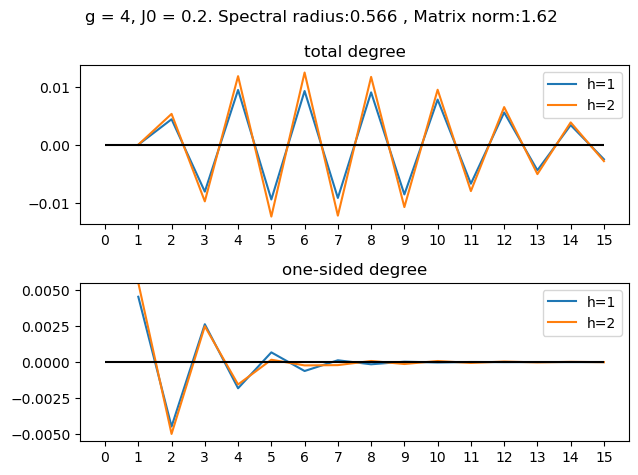

In [212]:
J0 = .2
g = 4
h = 1
b = np.array([.5, .5, .7, .5, .5, .7])
N_E =60
N_I = 15
Ns =np.array([N_E, N_E, N_I,  N_E, N_E, N_I])
nterms = 15
J = macro_weights(J = J0, h3 = h, h1 = h, g = g)
rho = np.max(np.abs(np.linalg.eigvals(J)))
norm = np.max(svdvals(J))

fig, axs = plt.subplots(2,1);
before  = cov_terms_2_side(J0 = J0, g = g, h = 1, b = b, N = Ns, nterms = nterms)
after = cov_terms_2_side(J0 = J0, g = g, h = 2, b = b, N = Ns, nterms = nterms)
axs[0].plot(range(1, nterms +1), before , label = "h=1");
axs[0].plot(range(1, nterms +1), after , label = "h=2");
axs[0].set_xticks(range(nterms+1));
axs[0].legend();
axs[0].hlines(y = [0], xmin = 0, xmax = nterms, color = "black");
axs[0].set_title("total degree")

before =cov_terms_1_side(J0 = J0, g = g, h = 1, b = b, N = Ns, nterms = nterms)
after = cov_terms_1_side(J0 = J0, g = g, h = 2, b = b, N = Ns, nterms = nterms)
axs[1].plot( range(1, nterms +1), before, label = "h=1");
axs[1].plot( range(1, nterms +1), after, label = "h=2");
axs[1].set_ylim(bottom = -np.max(np.abs(after)), top = np.max(np.abs(after)))
axs[1].legend();
axs[1].hlines(y = [0], xmin = 0, xmax = nterms, color = "black");
axs[1].set_xticks(range(nterms+1));
axs[1].set_title("one-sided degree")
plt.suptitle(f"g = {g}, J0 = {J0}. Spectral radius:{rho:.3f} , Matrix norm:{norm:.2f} ")
plt.tight_layout()


In [107]:
.56**3

0.17561600000000005

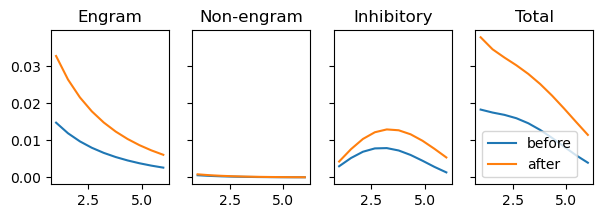

In [200]:
def f_CA3I(J0, g, h, b, N, p = 2):
    J = macro_weights(J = J0, h3 = h, h1 = h, g = g)
    if p == 2:
        r = y_0_quad(J, b)
        gain =  2*(J@r+b)
        J_lin =J* gain[...,None]
    else: 
        J_lin = J
        r = np.linalg.inv(np.eye(6) - J_lin)@ b
    return (-J0*g + J0**2 * (-g *h +g **2 -g))**2*r[2]/N[2]

def f_CA3E(J0, g, h, b, N, p = 2):
    J = macro_weights(J = J0, h3 = h, h1 = h, g = g)
    if p == 2:
        r = y_0_quad(J, b)
        gain =  2*(J@r+b)
        J_lin =J* gain[...,None]
    else: 
        J_lin = J
        r = np.linalg.inv(np.eye(6) - J_lin)@ b
    return ((1 + J0 *h + J0**2 *( h**2 - g + h))**2)*r[0]/N[0] 

def f_CA3P(J0, g, h, b, N, p = 2):
    J = macro_weights(J = J0, h3 = h, h1 = h, g = g)
    if p == 2:
        r = y_0_quad(J, b)
        gain =  2*(J@r+b)
        J_lin =J* gain[...,None]
    else: 
        J_lin = J
        r = np.linalg.inv(np.eye(6) - J_lin)@ b
    return (J0**2 *(1 + J0*( h - g + 1))**2)*r[1]/N[1]

g_min = 1
g_max = 6
gs = np.linspace(g_min, g_max, n_g)

fig, axs = plt.subplots(1, 4, figsize = (7,2), sharey = True)

I_before = np.array([f_CA3I(J0 = .2, g = g, h = 1, b=b, N=Ns, p = p) for g in gs])
I_after = np.array([f_CA3I(J0 = .2, g = g, h = 2, b=b, N=Ns, p = p) for g in gs])

E_before = np.array([f_CA3E(J0 = .2, g = g, h = 1, b=b, N=Ns, p = p) for g in gs])
E_after = np.array([f_CA3E(J0 = .2, g = g, h = 2, b=b, N=Ns, p = p) for g in gs])

N_before =  np.array([f_CA3P(J0 = .2, g = g, h = 1, b=b, N=Ns, p = p) for g in gs])
N_after = np.array([f_CA3P(J0 = .2, g = g, h = 2, b=b, N=Ns, p = p) for g in gs])



axs[0].plot(gs, E_before, label = "before")
axs[0].plot(gs, E_after, label = "after")
axs[0].set_title("Engram")

axs[1].plot(gs, N_before, label = "before")
axs[1].plot(gs, N_after, label = "after")
axs[1].set_title("Non-engram")

axs[2].plot(gs, I_before, label = "before")
axs[2].plot(gs, I_after, label = "after")
axs[2].set_title("Inhibitory")

axs[3].plot(gs,E_before + N_before + I_before, label = "before")

axs[3].plot(gs, E_after + N_after + I_after, label = "after")

axs[3].set_title("Total")

plt.legend()



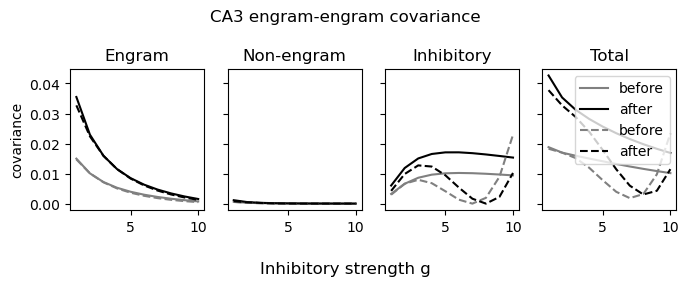

In [214]:
def ca3_internal_cov(J0, g, h, b, N, p = 2):
    J = macro_weights(J = J0, h3 = h, h1 = h, g = g)
    if p == 2:
        r = y_0_quad(J, b)
        gain =  2*(J@r+b)
        J_lin =J* gain[...,None]
    else: 
        J_lin = J
        r = np.linalg.inv(np.eye(6) - J_lin)@ b
    R = np.diag(r/N)
    R3 = R[:3, :3]
    J_CA3 = J_lin[:3, :3]
    D_33 = np.linalg.inv(np.eye(3) - J_CA3)
    return (D_33 @ R3 @ D_33.T)

def f_CA3I_full(J0, g, h, b, N, p = 2):
    J = macro_weights(J = J0, h3 = h, h1 = h, g = g)
    if p == 2:
        r = y_0_quad(J, b)
        gain =  2*(J@r+b)
        J_lin =J* gain[...,None]
    else: 
        J_lin = J
        r = np.linalg.inv(np.eye(6) - J_lin)@ b
    R = np.diag(r/N)
    R3 = R[:3, :3]
    J_CA3 = J_lin[:3, :3]
    D_33 = np.linalg.inv(np.eye(3) - J_CA3)
    return D_33[0,2]**2 * R3[2,2]
   
def f_CA3E_full(J0, g, h, b, N, p = 2):
    J = macro_weights(J = J0, h3 = h, h1 = h, g = g)
    if p == 2:
        r = y_0_quad(J, b)
        gain =  2*(J@r+b)
        J_lin =J* gain[...,None]
    else: 
        J_lin = J
        r = np.linalg.inv(np.eye(6) - J_lin)@ b
    R = np.diag(r/N)
    R3 = R[:3, :3]
    J_CA3 = J_lin[:3, :3]
    D_33 = np.linalg.inv(np.eye(3) - J_CA3)
    return D_33[0,0]**2 * R3[0,0] 

def f_CA3P_full(J0, g, h, b, N, p = 2):
    J = macro_weights(J = J0, h3 = h, h1 = h, g = g)
    if p == 2:
        r = y_0_quad(J, b)
        gain =  2*(J@r+b)
        J_lin =J* gain[...,None]
    else: 
        J_lin = J
        r = np.linalg.inv(np.eye(6) - J_lin)@ b
    R = np.diag(r/N)
    R3 = R[:3, :3]
    J_CA3 = J_lin[:3, :3]
    D_33 = np.linalg.inv(np.eye(3) - J_CA3)
    return D_33[0,1]**2 * R3[1,1]

g_min = 1
g_max = 10
p = 1
gs = np.linspace(g_min, g_max, n_g)

fig, axs = plt.subplots(1, 4, figsize = (7,2.75), sharey = True, sharex = True )

I_before = np.array([f_CA3I_full(J0 = .2, g = g, h = 1, b=b, N=Ns, p = p) for g in gs])
I_after = np.array([f_CA3I_full(J0 = .2, g = g, h = 2, b=b, N=Ns, p = p) for g in gs])
I_before_approx = np.array([f_CA3I(J0 = .2, g = g, h = 1, b=b, N=Ns, p = p) for g in gs])
I_after_approx = np.array([f_CA3I(J0 = .2, g = g, h = 2, b=b, N=Ns, p = p) for g in gs])

E_before= np.array([f_CA3E_full(J0 = .2, g = g, h = 1, b=b, N=Ns, p = p) for g in gs])
E_after = np.array([f_CA3E_full(J0 = .2, g = g, h = 2, b=b, N=Ns, p = p) for g in gs])
E_before_approx= np.array([f_CA3E(J0 = .2, g = g, h = 1, b=b, N=Ns, p = p) for g in gs])
E_after_approx= np.array([f_CA3E(J0 = .2, g = g, h = 2, b=b, N=Ns, p = p) for g in gs])

N_before =  np.array([f_CA3P_full(J0 = .2, g = g, h = 1, b=b, N=Ns, p = p) for g in gs])
N_after = np.array([f_CA3P_full(J0 = .2, g = g, h = 2, b=b, N=Ns, p = p) for g in gs])
N_before_approx =  np.array([f_CA3P(J0 = .2, g = g, h = 1, b=b, N=Ns, p = p) for g in gs])
N_after_approx = np.array([f_CA3P(J0 = .2, g = g, h = 2, b=b, N=Ns, p = p) for g in gs])

tot_before=  np.array([ca3_internal_cov(J0=J0, g=g, h=1,b=b, N=Ns, p = p)[0,0] for g in gs])
tot_after =  np.array([ca3_internal_cov(J0=J0, g=g, h=2,b=b, N=Ns, p = p)[0,0] for g in gs])

axs[0].plot(gs, E_before, label = "before",color = "gray")
axs[0].plot(gs, E_after, label = "after", color = "black")
axs[0].plot(gs, E_before_approx, label = "before",color = "gray", linestyle = "--")
axs[0].plot(gs, E_after_approx, label = "after", color = "black", linestyle = "--")
axs[0].set_title("Engram")
axs[0].set_ylabel("covariance")


axs[1].plot(gs, N_before, label = "before", color = "gray")
axs[1].plot(gs, N_after, label = "after", color = "black")
axs[1].plot(gs, N_before_approx, label = "before", color = "gray", linestyle = "--")
axs[1].plot(gs, N_after_approx, label = "after", color = "black", linestyle = "--")
axs[1].set_title("Non-engram")

axs[2].plot(gs, I_before, label = "before", color = "gray")
axs[2].plot(gs, I_after, label = "after", color = "black")
axs[2].plot(gs, I_before_approx, label = "before", color = "gray", linestyle = "--")
axs[2].plot(gs, I_after_approx, label = "after", color = "black", linestyle = "--")
axs[2].set_title("Inhibitory")

axs[3].plot(gs,E_before + N_before + I_before, label = "before", color = "gray")
axs[3].plot(gs, E_after + N_after + I_after, label = "after", color = "black")
axs[3].plot(gs,E_before_approx + N_before_approx + I_before_approx, label = "before", color = "gray", linestyle ="--")
axs[3].plot(gs, E_after_approx + N_after_approx + I_after_approx, label = "after", color = "black", linestyle = "--")
axs[3].set_title("Total")

fig.supxlabel("Inhibitory strength g")
fig.suptitle("CA3 engram-engram covariance")
plt.tight_layout()
plt.legend()
